In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import wandb

import sys
sys.path.append('../../../src/')
from build_model import xcit_small
from train_functions import train_epochs
from dataset_functions import hdf5_dataset, list_to_dict, viz_dataloader
from visualization_functions import show_images

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5,6,7"
print(os.environ["CUDA_VISIBLE_DEVICES"])
device = torch.device('cuda')

2,3,4,5,6,7


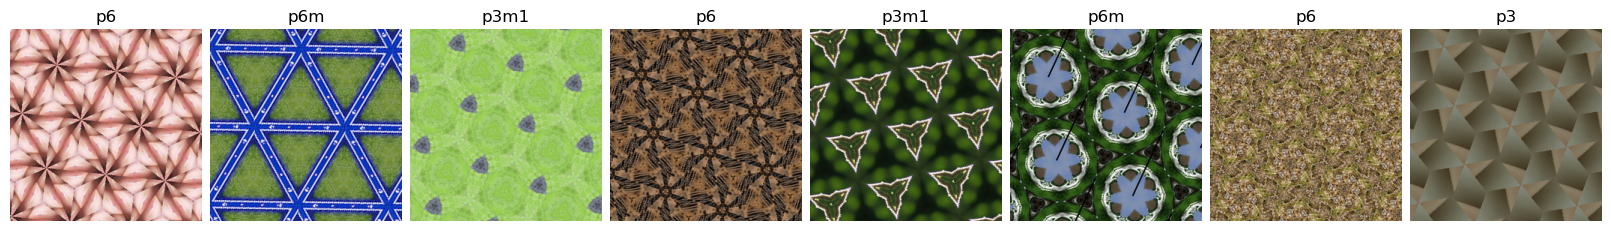

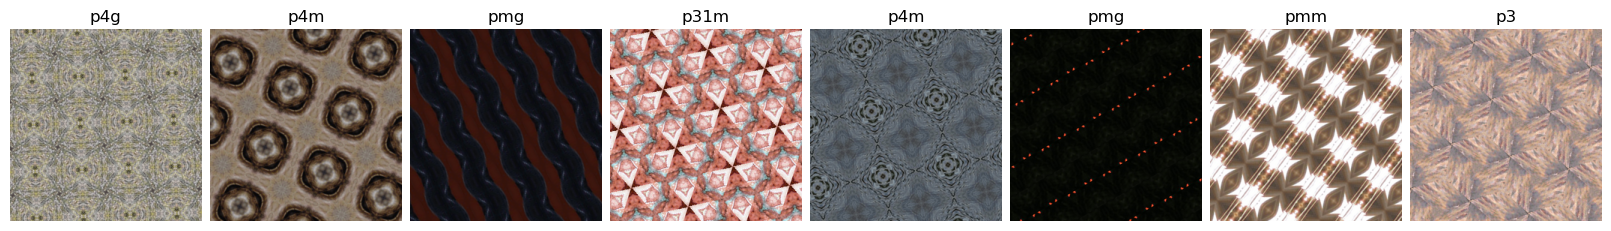

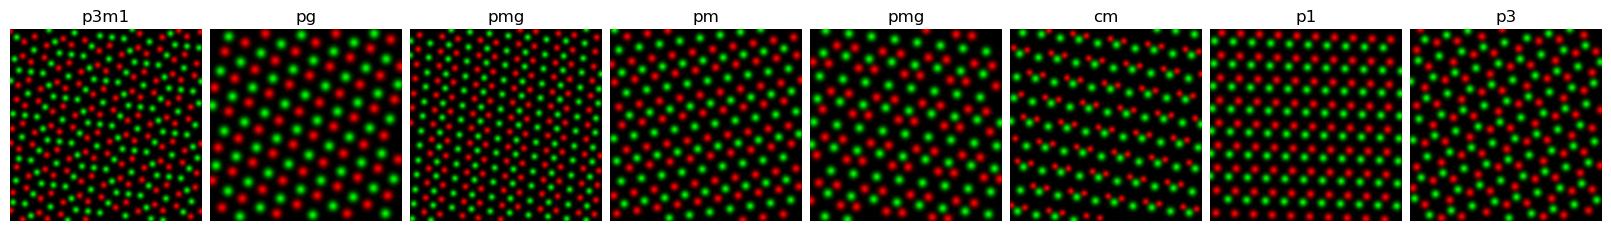

In [12]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 
                 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
train_ds = hdf5_dataset('../../../../imagenet_v4_rot_10m_train_unchunked.h5', folder='train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=400, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter)

valid_ds = hdf5_dataset('../../../../imagenet_v4_rot_2m_valid_unchunked.h5', folder='valid', transform=transforms.ToTensor())
valid_dl = DataLoader(valid_ds, batch_size=400, shuffle=True, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter)

# atom
test_ds = hdf5_dataset('../../../../atom_v4_rot_2m_unchunked_fixed.h5', folder='test', transform=transforms.ToTensor())
test_dl = DataLoader(test_ds, batch_size=400, shuffle=True, num_workers=4)
viz_dataloader(test_dl, label_converter=label_converter)

# train

In [ ]:
import timm
timm.list_models('xcit*')

['xcit_large_24_p8_224',
 'xcit_large_24_p8_384',
 'xcit_large_24_p16_224',
 'xcit_large_24_p16_384',
 'xcit_medium_24_p8_224',
 'xcit_medium_24_p8_384',
 'xcit_medium_24_p16_224',
 'xcit_medium_24_p16_384',
 'xcit_nano_12_p8_224',
 'xcit_nano_12_p8_384',
 'xcit_nano_12_p16_224',
 'xcit_nano_12_p16_384',
 'xcit_small_12_p8_224',
 'xcit_small_12_p8_384',
 'xcit_small_12_p16_224',
 'xcit_small_12_p16_384',
 'xcit_small_24_p8_224',
 'xcit_small_24_p8_384',
 'xcit_small_24_p16_224',
 'xcit_small_24_p16_384',
 'xcit_tiny_12_p8_224',
 'xcit_tiny_12_p8_384',
 'xcit_tiny_12_p16_224',
 'xcit_tiny_12_p16_384',
 'xcit_tiny_24_p8_224',
 'xcit_tiny_24_p8_384',
 'xcit_tiny_24_p16_224',
 'xcit_tiny_24_p16_384']

In [13]:
model = xcit_small(3, 17)
model = nn.DataParallel(model)
print(model.to(device))
print(model(torch.randn(2, 3, 256, 256)).shape)

DataParallel(
  (module): Xcit(
    (patch_embed): ConvPatchEmbed(
      (proj): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Sequential(
          (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (3): GELU(approximate='none')
        (4): Sequential(
          (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (pos_embed): PositionalEncodingFourier(
      (token_projection): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1))
    )
    (pos_drop): D

In [14]:
config = {
        'dataset': '10 million datasets',
        'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
        'optimizer': 'Adam',
        'scheduler': 'OneCycleLR',
        }

NAME = '01102024-benchmark-XCiT-v4_10m'

In [15]:
wandb.login()

proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, save_code=True, config=config)
config = wandb.config

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [16]:
lr = 1e-3
start = 0
epochs = 20

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=epochs, max_lr=lr, 
                            steps_per_epoch=len(train_dl))

history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl, test_dl, epochs=epochs, start=start, 
                       scheduler=scheduler, model_name=NAME, model_dir='../../../saved_models/', tracking=True)

Epoch: 1/20


  0%|          | 0/25001 [00:00<?, ?it/s]

100%|██████████| 25001/25001 [10:49:02<00:00,  1.56s/it] 


Training: Loss: 0.1682, Accuracy: 94.2243%, Time: 649.0464mins


100%|██████████| 5001/5001 [39:01<00:00,  2.14it/s]


Validation : Loss : 0.0338, Accuracy: 98.9226%, Time: 39.03mins


100%|██████████| 4682/4682 [35:45<00:00,  2.18it/s]


Validation : Loss : 4.6371, Accuracy: 38.8099%, Time: 35.76mins
Epoch: 2/20


100%|██████████| 25001/25001 [10:49:27<00:00,  1.56s/it] 


Training: Loss: 0.0246, Accuracy: 99.2161%, Time: 649.4517mins


100%|██████████| 5001/5001 [39:03<00:00,  2.13it/s]


Validation : Loss : 0.0203, Accuracy: 99.3515%, Time: 39.06mins


100%|██████████| 4682/4682 [36:18<00:00,  2.15it/s]


Validation : Loss : 4.6990, Accuracy: 42.3169%, Time: 36.30mins
Epoch: 3/20


100%|██████████| 25001/25001 [10:49:16<00:00,  1.56s/it] 


Training: Loss: 0.0132, Accuracy: 99.5885%, Time: 649.2717mins


100%|██████████| 5001/5001 [39:01<00:00,  2.14it/s]


Validation : Loss : 0.0151, Accuracy: 99.5396%, Time: 39.03mins


100%|██████████| 4682/4682 [36:41<00:00,  2.13it/s]


Validation : Loss : 4.3093, Accuracy: 46.5210%, Time: 36.69mins
Epoch: 4/20


100%|██████████| 25001/25001 [10:48:59<00:00,  1.56s/it] 


Training: Loss: 0.0080, Accuracy: 99.7528%, Time: 648.9960mins


100%|██████████| 5001/5001 [39:19<00:00,  2.12it/s]


Validation : Loss : 0.0058, Accuracy: 99.8271%, Time: 39.33mins


100%|██████████| 4682/4682 [36:31<00:00,  2.14it/s]


Validation : Loss : 4.3848, Accuracy: 45.8937%, Time: 36.52mins
Epoch: 5/20


100%|██████████| 25001/25001 [10:48:49<00:00,  1.56s/it] 


Training: Loss: 0.0056, Accuracy: 99.8241%, Time: 648.8252mins


100%|██████████| 5001/5001 [39:43<00:00,  2.10it/s]  


Validation : Loss : 0.0053, Accuracy: 99.8317%, Time: 39.73mins


100%|██████████| 4682/4682 [37:05<00:00,  2.10it/s] 


Validation : Loss : 3.8970, Accuracy: 48.2355%, Time: 37.09mins
Epoch: 6/20


100%|██████████| 25001/25001 [10:48:44<00:00,  1.56s/it] 


Training: Loss: 0.0045, Accuracy: 99.8582%, Time: 648.7389mins


100%|██████████| 5001/5001 [39:13<00:00,  2.12it/s]  


Validation : Loss : 0.0041, Accuracy: 99.8671%, Time: 39.23mins


100%|██████████| 4682/4682 [37:11<00:00,  2.10it/s] 


Validation : Loss : 3.8365, Accuracy: 47.9850%, Time: 37.19mins
Epoch: 7/20


100%|██████████| 25001/25001 [10:48:49<00:00,  1.56s/it] 


Training: Loss: 0.0036, Accuracy: 99.8836%, Time: 648.8245mins


100%|██████████| 5001/5001 [39:25<00:00,  2.11it/s]


Validation : Loss : 0.0033, Accuracy: 99.8906%, Time: 39.42mins


100%|██████████| 4682/4682 [36:57<00:00,  2.11it/s]


Validation : Loss : 2.5688, Accuracy: 53.8813%, Time: 36.96mins
Epoch: 8/20


100%|██████████| 25001/25001 [10:48:22<00:00,  1.56s/it] 


Training: Loss: 0.0031, Accuracy: 99.8984%, Time: 648.3671mins


100%|██████████| 5001/5001 [38:10<00:00,  2.18it/s]


Validation : Loss : 0.0027, Accuracy: 99.9061%, Time: 38.17mins


100%|██████████| 4682/4682 [35:26<00:00,  2.20it/s]


Validation : Loss : 3.5064, Accuracy: 49.4496%, Time: 35.45mins
Epoch: 9/20


100%|██████████| 25001/25001 [10:44:16<00:00,  1.55s/it] 


Training: Loss: 0.0028, Accuracy: 99.9068%, Time: 644.2674mins


100%|██████████| 5001/5001 [38:21<00:00,  2.17it/s]


Validation : Loss : 0.0027, Accuracy: 99.9043%, Time: 38.36mins


100%|██████████| 4682/4682 [35:54<00:00,  2.17it/s]


Validation : Loss : 3.4996, Accuracy: 49.0242%, Time: 35.91mins
Epoch: 10/20


100%|██████████| 25001/25001 [10:44:17<00:00,  1.55s/it] 


Training: Loss: 0.0024, Accuracy: 99.9175%, Time: 644.2989mins


100%|██████████| 5001/5001 [38:14<00:00,  2.18it/s]


Validation : Loss : 0.0046, Accuracy: 99.8506%, Time: 38.25mins


100%|██████████| 4682/4682 [35:35<00:00,  2.19it/s]


Validation : Loss : 3.9486, Accuracy: 45.0404%, Time: 35.59mins
Epoch: 11/20


100%|██████████| 25001/25001 [10:43:32<00:00,  1.54s/it] 


Training: Loss: 0.0022, Accuracy: 99.9262%, Time: 643.5426mins


100%|██████████| 5001/5001 [38:09<00:00,  2.18it/s]


Validation : Loss : 0.0027, Accuracy: 99.9088%, Time: 38.16mins


100%|██████████| 4682/4682 [35:38<00:00,  2.19it/s]


Validation : Loss : 2.7462, Accuracy: 45.9303%, Time: 35.64mins
Epoch: 12/20


100%|██████████| 25001/25001 [10:43:35<00:00,  1.54s/it] 


Training: Loss: 0.0019, Accuracy: 99.9315%, Time: 643.5952mins


100%|██████████| 5001/5001 [38:06<00:00,  2.19it/s]


Validation : Loss : 0.0023, Accuracy: 99.9206%, Time: 38.10mins


100%|██████████| 4682/4682 [35:43<00:00,  2.18it/s]


Validation : Loss : 4.1690, Accuracy: 49.1124%, Time: 35.72mins
Epoch: 13/20


100%|██████████| 25001/25001 [10:43:47<00:00,  1.55s/it] 


Training: Loss: 0.0017, Accuracy: 99.9396%, Time: 643.7988mins


100%|██████████| 5001/5001 [38:18<00:00,  2.18it/s]


Validation : Loss : 0.0019, Accuracy: 99.9323%, Time: 38.31mins


100%|██████████| 4682/4682 [35:45<00:00,  2.18it/s]


Validation : Loss : 3.4123, Accuracy: 52.2947%, Time: 35.76mins
Epoch: 14/20


100%|██████████| 25001/25001 [10:44:37<00:00,  1.55s/it] 


Training: Loss: 0.0015, Accuracy: 99.9439%, Time: 644.6174mins


100%|██████████| 5001/5001 [38:20<00:00,  2.17it/s]


Validation : Loss : 0.0019, Accuracy: 99.9358%, Time: 38.35mins


100%|██████████| 4682/4682 [35:47<00:00,  2.18it/s]


Validation : Loss : 4.4575, Accuracy: 49.1736%, Time: 35.79mins
Epoch: 15/20


100%|██████████| 25001/25001 [10:45:18<00:00,  1.55s/it] 


Training: Loss: 0.0014, Accuracy: 99.9494%, Time: 645.3085mins


100%|██████████| 5001/5001 [39:03<00:00,  2.13it/s]


Validation : Loss : 0.0017, Accuracy: 99.9412%, Time: 39.06mins


100%|██████████| 4682/4682 [50:20<00:00,  1.55it/s]  


Validation : Loss : 4.2697, Accuracy: 52.7802%, Time: 50.35mins
Epoch: 16/20


100%|██████████| 25001/25001 [10:51:36<00:00,  1.56s/it] 


Training: Loss: 0.0012, Accuracy: 99.9534%, Time: 651.6108mins


100%|██████████| 5001/5001 [38:35<00:00,  2.16it/s]  


Validation : Loss : 0.0018, Accuracy: 99.9401%, Time: 38.58mins


100%|██████████| 4682/4682 [36:17<00:00,  2.15it/s]  


Validation : Loss : 4.1977, Accuracy: 51.5689%, Time: 36.29mins
Epoch: 17/20


100%|██████████| 25001/25001 [10:45:35<00:00,  1.55s/it] 


Training: Loss: 0.0012, Accuracy: 99.9573%, Time: 645.5934mins


100%|██████████| 5001/5001 [39:34<00:00,  2.11it/s]


Validation : Loss : 0.0017, Accuracy: 99.9414%, Time: 39.57mins


100%|██████████| 4682/4682 [36:45<00:00,  2.12it/s]


Validation : Loss : 4.7585, Accuracy: 52.1446%, Time: 36.77mins
Epoch: 18/20


100%|██████████| 25001/25001 [10:47:40<00:00,  1.55s/it] 


Training: Loss: 0.0011, Accuracy: 99.9607%, Time: 647.6744mins


100%|██████████| 5001/5001 [38:43<00:00,  2.15it/s]


Validation : Loss : 0.0019, Accuracy: 99.9425%, Time: 38.73mins


100%|██████████| 4682/4682 [36:05<00:00,  2.16it/s]


Validation : Loss : 5.8805, Accuracy: 51.5809%, Time: 36.09mins
Epoch: 19/20


100%|██████████| 25001/25001 [10:46:48<00:00,  1.55s/it] 


Training: Loss: 0.0010, Accuracy: 99.9628%, Time: 646.8085mins


100%|██████████| 5001/5001 [38:22<00:00,  2.17it/s]


Validation : Loss : 0.0020, Accuracy: 99.9434%, Time: 38.37mins


100%|██████████| 4682/4682 [35:49<00:00,  2.18it/s]


Validation : Loss : 6.0929, Accuracy: 52.8928%, Time: 35.82mins
Epoch: 20/20


100%|██████████| 25001/25001 [10:49:27<00:00,  1.56s/it] 


Training: Loss: 0.0010, Accuracy: 99.9642%, Time: 649.4551mins


100%|██████████| 5001/5001 [38:38<00:00,  2.16it/s]


Validation : Loss : 0.0020, Accuracy: 99.9438%, Time: 38.64mins


100%|██████████| 4682/4682 [36:17<00:00,  2.15it/s]


Validation : Loss : 6.3293, Accuracy: 52.4287%, Time: 36.29mins


# analyze

In [2]:
from analysis_functions import confusion_matrix, plot_cm

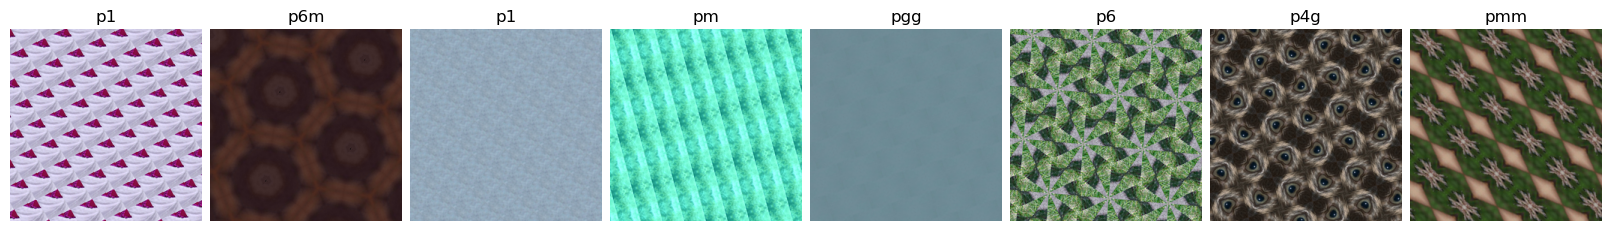

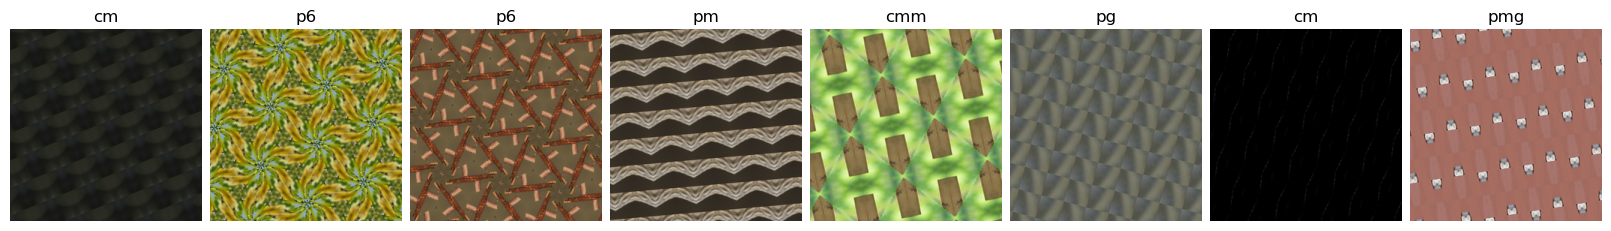

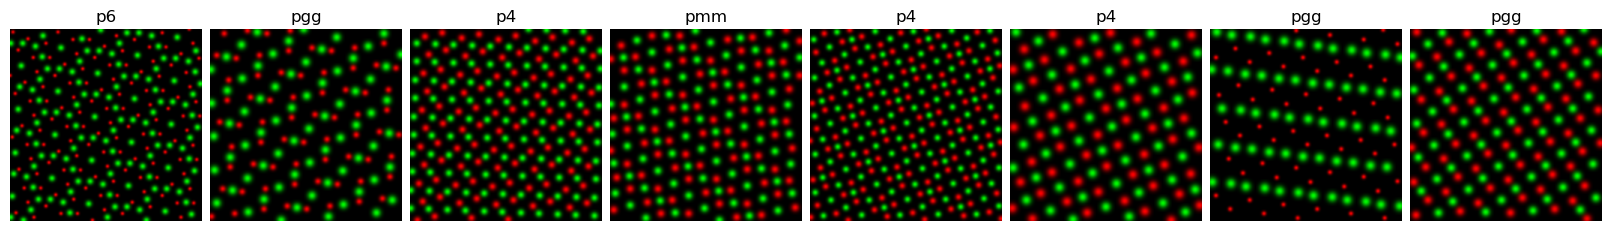

In [3]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 
                 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
train_ds = hdf5_dataset('../../../../imagenet_v4_rot_10m_train_unchunked.h5', folder='train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter)

valid_ds = hdf5_dataset('../../../../imagenet_v4_rot_2m_valid_unchunked.h5', folder='valid', transform=transforms.ToTensor())
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter)

# atom
test_ds = hdf5_dataset('../../../../atom_v4_rot_2m_unchunked_fixed.h5', folder='test', transform=transforms.ToTensor())
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, num_workers=4)
viz_dataloader(test_dl, label_converter=label_converter)

In [4]:
device = torch.device('cuda:0')
model = torch.load('../../../saved_models/01102024-benchmark-XCiT-v4_10m/01102024-benchmark-XCiT-v4_10m-epoch-20.pt').module
model = model.to(device)

NAME = '01102024-benchmark-XCiT-v4_10m'
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 
                    'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']                  

In [5]:
cm = confusion_matrix(model, train_dl, symmetry_classes, device, n_batches='all')
np.save(NAME+'-train_cm.npy', cm)

100%|██████████| 156252/156252 [14:30:41<00:00,  2.99it/s]  

Sum for true labels:


p1        p2        pm        pg        cm       pmm       pmg  \
0  588308.0  588239.0  588239.0  588233.0  588232.0  588231.0  588236.0   

        pgg       cmm        p4       p4m       p4g        p3      p3m1  \
0  588232.0  588239.0  588237.0  588238.0  588239.0  588239.0  588224.0   

       p31m        p6       p6m  
0  588239.0  588238.0  588237.0

Accuracy for these batches: 0.999640802873577



ImageNet Symmetry Dataset


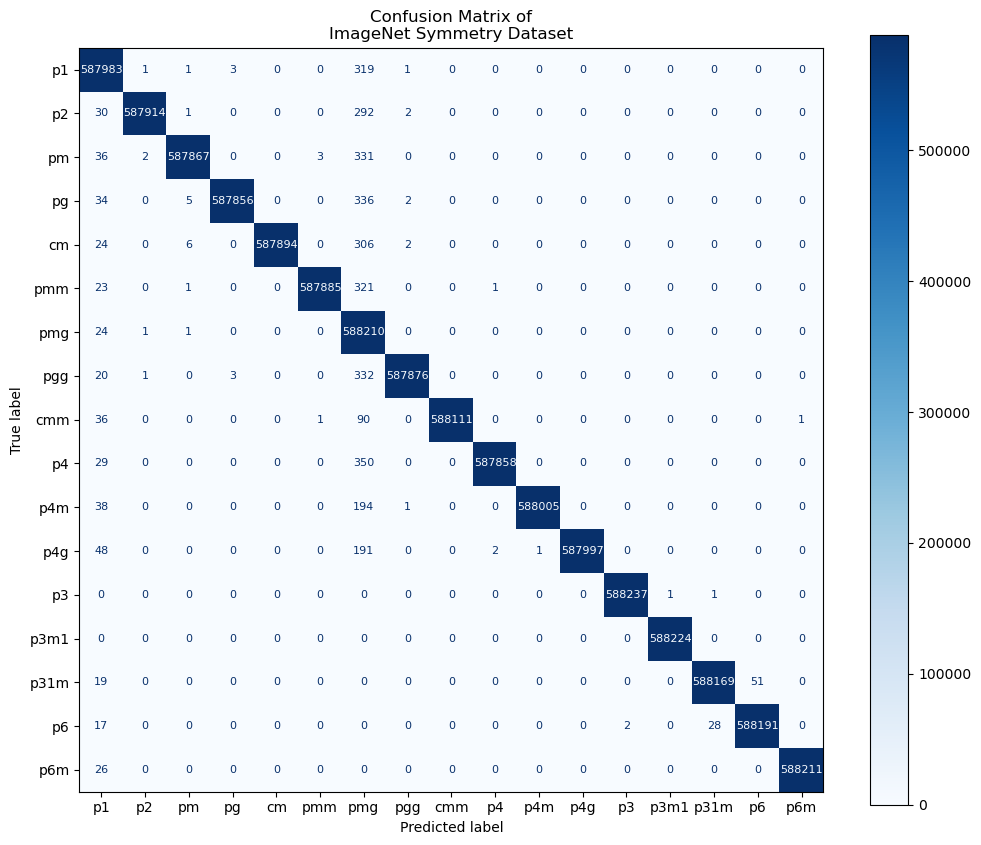

In [11]:
# cm = np.load('11172021-benchmark_atom-fpn_spatial-transfer_learning-train.npy')

plot_cm(cm, symmetry_classes, file_path=f'{NAME}-train_cm', title='\nImageNet Symmetry Dataset', style='simple', font_size=8)
# plot_cm(cm, symmetry_classes, save_file=None, style='with_axis')

In [12]:
cm = confusion_matrix(model, valid_dl, symmetry_classes, device, n_batches='all')
np.save(NAME+'-valid_cm.npy', cm)

  0%|          | 0/31251 [00:00<?, ?it/s]

100%|██████████| 31251/31251 [2:54:10<00:00,  2.99it/s]  

Sum for true labels:


p1        p2        pm        pg        cm       pmm       pmg  \
0  117670.0  117647.0  117647.0  117647.0  117646.0  117646.0  117648.0   

        pgg       cmm        p4       p4m       p4g        p3      p3m1  \
0  117647.0  117647.0  117646.0  117647.0  117648.0  117647.0  117645.0   

       p31m        p6       p6m  
0  117645.0  117646.0  117647.0

Accuracy for these batches: 0.999438004495964



ImageNet Symmetry Dataset


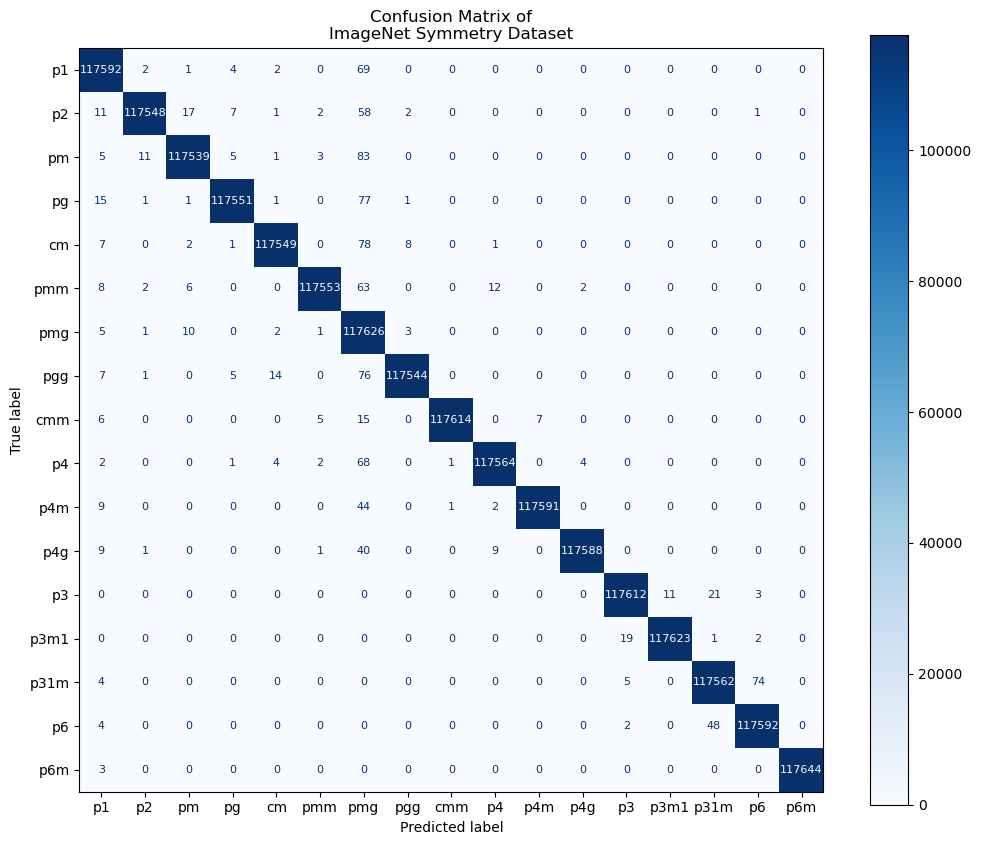

In [13]:
# cm = np.load('11172021-benchmark_imagenet-fpn_spatial-transfer_learning-valid.npy')

plot_cm(cm, symmetry_classes, file_path=f'{NAME}-valid_cm', title='\nImageNet Symmetry Dataset', style='simple', font_size=8)
# plot_cm(cm, symmetry_classes, save_file=None, style='with_axis')

In [14]:
cm = confusion_matrix(model, test_dl, symmetry_classes, device, n_batches='all')
np.save(NAME+'-test_cm.npy', cm)

  0%|          | 0/29257 [00:00<?, ?it/s]

100%|██████████| 29257/29257 [2:42:30<00:00,  3.00it/s]  

Sum for true labels:


p1        p2        pm        pg        cm       pmm       pmg  \
0  110143.0  110143.0  110143.0  110143.0  110143.0  110143.0  110143.0   

        pgg       cmm        p4       p4m       p4g        p3      p3m1  \
0  110143.0  110143.0  110143.0  110143.0  110143.0  110143.0  110143.0   

       p31m        p6       p6m  
0  110143.0  110143.0  110143.0

Accuracy for these batches: 0.5242868762587246



Atom Symmetry Dataset


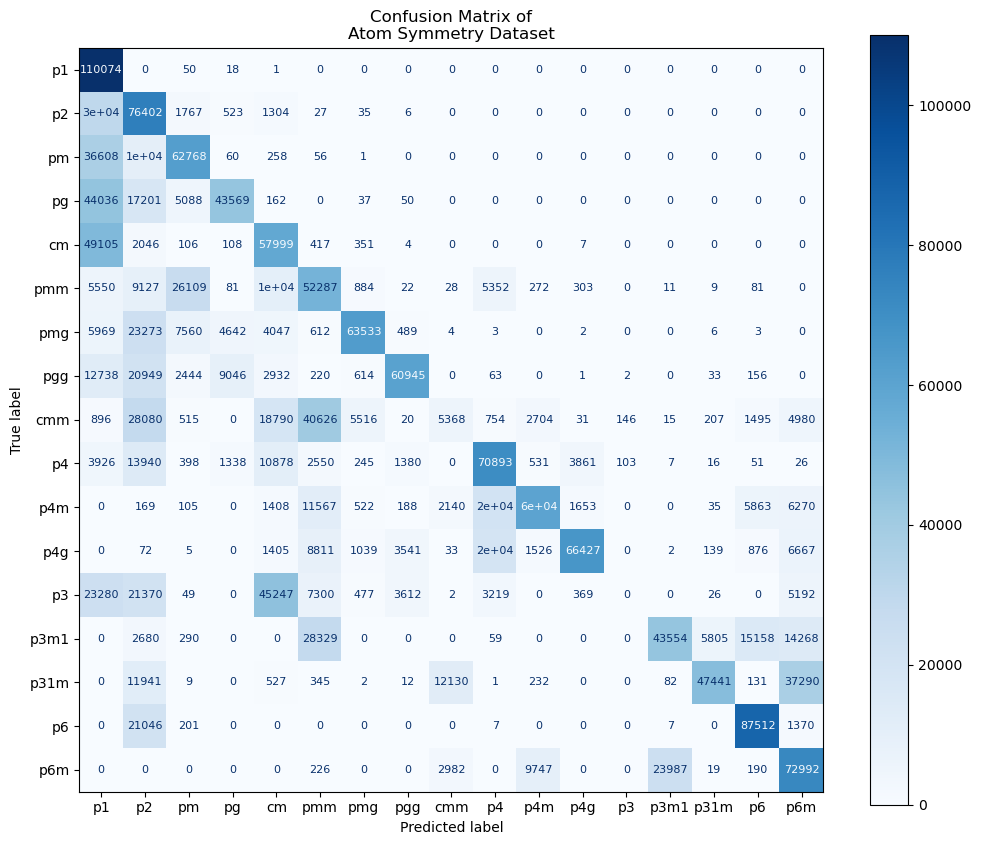

In [15]:
# cm = np.load('05232022-benchmark-resnet50_from_scratch-dataset_v3-test.npy')

plot_cm(cm, symmetry_classes, file_path=f'{NAME}-test_cm', title='\nAtom Symmetry Dataset', style='simple', font_size=8)
# plot_cm(cm, symmetry_classes, save_file=None, style='with_axis')